In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Copy data folder from drive to this machine
#!mkdir -p /content/images
# Copy the necessary files.
!cp /content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/utils.py /content/utils.py
!cp /content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/trainer.py /content/trainer.py
!cp /content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/scanner.py /content/scanner.py
!cp /content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/pruner.py /content/pruner.py
!cp /content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/model.py /content/model.py

Mounted at /content/drive


In [2]:
!pip install torchinfo

**Table of contents**<a id='toc0_'></a>    
- [Utils](#toc1_)    
- [Dataloading](#toc2_)    
- [Useful Constants](#toc3_)    
- [Initial Training](#toc4_)    
- [Pruning](#toc5_)    
  - [Finegrained Pruning](#toc5_1_)    
    - [Finetuning](#toc5_1_1_)    
  - [Kernel Pruning](#toc5_2_)    
    - [Finetuning](#toc5_2_1_)    
  - [Filter Pruning](#toc5_3_)    
    - [Finetuning](#toc5_3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [3]:
import torch
import torch.nn as nn
import torchinfo
import pruner
import model
import trainer
import scanner
import utils

# <a id='toc1_'></a>[Utils](#toc0_)

In [4]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy.

    Args:
        history (dict): A dictionary containing 'train_loss', 'train_acc', 'val_loss', and 'val_acc' lists.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss', linewidth=2, markersize=5)
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss', linewidth=2, markersize=5)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy', linewidth=2, markersize=5)
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy', linewidth=2, markersize=5)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()


# <a id='toc2_'></a>[Dataloading](#toc0_)

In [5]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, ToTensor, Compose
from torch.utils.data import DataLoader

image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

100%|██████████| 170498071/170498071 [00:13<00:00, 12617135.24it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


# <a id='toc3_'></a>[Useful Constants](#toc0_)

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# <a id='toc4_'></a>[Initial Training](#toc0_)

In [6]:
vgg16 = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

In [8]:
torchinfo.summary(vgg16,(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 2, 2]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-7                       [1, 64, 32, 32]           36,928
│    └─BatchNorm2d: 2-8                  [1, 64, 32, 32]           128
│    └─ReLU: 2-9                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 64, 16, 16]           --
│    └─Conv2d: 2-11                      [1, 128, 16, 16]          73,8

In [9]:
configs = trainer.TrainConfigs(
    learning_rate = 1e-4,
    epochs=100,
    batch_size = 64,
    loss_fn = nn.CrossEntropyLoss(),
    device = DEVICE
)

In [10]:
vgg16_optimizer = torch.optim.Adam(vgg16.parameters(),lr=configs.learning_rate)

In [11]:
trainer_vgg16 = trainer.Trainer(configs,
                                vgg16,
                                vgg16_optimizer,
                                dataloader['train'],
                                dataloader['test'])

In [12]:
trainer_vgg16.train()

Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/100: Train Loss: 2.1879 | Train Acc: 0.1537 | Val Loss: 2.0692 | Val Acc: 0.1846


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/100: Train Loss: 1.9231 | Train Acc: 0.1858 | Val Loss: 1.8560 | Val Acc: 0.1874


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/100: Train Loss: 1.8265 | Train Acc: 0.1902 | Val Loss: 1.7829 | Val Acc: 0.1930


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/100: Train Loss: 1.7883 | Train Acc: 0.1959 | Val Loss: 1.7516 | Val Acc: 0.1959


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/100: Train Loss: 1.7389 | Train Acc: 0.1979 | Val Loss: 1.7032 | Val Acc: 0.1971


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/100: Train Loss: 1.6962 | Train Acc: 0.2056 | Val Loss: 1.8115 | Val Acc: 0.2022


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/100: Train Loss: 1.6563 | Train Acc: 0.2557 | Val Loss: 1.5877 | Val Acc: 0.3446


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/100: Train Loss: 1.5119 | Train Acc: 0.3670 | Val Loss: 1.4438 | Val Acc: 0.3935


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/100: Train Loss: 1.4190 | Train Acc: 0.4074 | Val Loss: 1.3874 | Val Acc: 0.4284


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/100: Train Loss: 1.3418 | Train Acc: 0.4478 | Val Loss: 1.3510 | Val Acc: 0.4675


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/100: Train Loss: 1.2650 | Train Acc: 0.4959 | Val Loss: 1.2865 | Val Acc: 0.5093


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/100: Train Loss: 1.1773 | Train Acc: 0.5415 | Val Loss: 1.1815 | Val Acc: 0.5391


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/100: Train Loss: 1.1098 | Train Acc: 0.5825 | Val Loss: 1.1261 | Val Acc: 0.6140


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/100: Train Loss: 1.0356 | Train Acc: 0.6222 | Val Loss: 0.9747 | Val Acc: 0.6451


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/100: Train Loss: 0.9757 | Train Acc: 0.6480 | Val Loss: 0.9642 | Val Acc: 0.6660


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/100: Train Loss: 0.9317 | Train Acc: 0.6710 | Val Loss: 0.9639 | Val Acc: 0.6722


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/100: Train Loss: 0.8868 | Train Acc: 0.6895 | Val Loss: 0.9426 | Val Acc: 0.6913


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/100: Train Loss: 0.8534 | Train Acc: 0.7065 | Val Loss: 0.8309 | Val Acc: 0.7109


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/100: Train Loss: 0.8097 | Train Acc: 0.7225 | Val Loss: 0.8656 | Val Acc: 0.7182


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/100: Train Loss: 0.7870 | Train Acc: 0.7340 | Val Loss: 0.8505 | Val Acc: 0.7185


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/100: Train Loss: 0.7553 | Train Acc: 0.7459 | Val Loss: 0.8676 | Val Acc: 0.7163


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/100: Train Loss: 0.7309 | Train Acc: 0.7544 | Val Loss: 0.8583 | Val Acc: 0.7105


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/100: Train Loss: 0.7073 | Train Acc: 0.7647 | Val Loss: 0.9523 | Val Acc: 0.7160


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/100: Train Loss: 0.6792 | Train Acc: 0.7751 | Val Loss: 0.7926 | Val Acc: 0.7337


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/100: Train Loss: 0.6613 | Train Acc: 0.7819 | Val Loss: 0.7566 | Val Acc: 0.7772


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/100: Train Loss: 0.6350 | Train Acc: 0.7901 | Val Loss: 0.7526 | Val Acc: 0.7655


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/100: Train Loss: 0.6140 | Train Acc: 0.7998 | Val Loss: 0.7425 | Val Acc: 0.7710


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/100: Train Loss: 0.5960 | Train Acc: 0.8047 | Val Loss: 0.8366 | Val Acc: 0.7582


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/100: Train Loss: 0.5903 | Train Acc: 0.8107 | Val Loss: 0.6861 | Val Acc: 0.7896


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/100: Train Loss: 0.5685 | Train Acc: 0.8180 | Val Loss: 0.8340 | Val Acc: 0.7595


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/100: Train Loss: 0.5547 | Train Acc: 0.8227 | Val Loss: 0.6893 | Val Acc: 0.8004


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/100: Train Loss: 0.5383 | Train Acc: 0.8276 | Val Loss: 0.7193 | Val Acc: 0.7954


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/100: Train Loss: 0.5225 | Train Acc: 0.8337 | Val Loss: 0.7117 | Val Acc: 0.7946


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/100: Train Loss: 0.5120 | Train Acc: 0.8383 | Val Loss: 0.7377 | Val Acc: 0.7957


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/100: Train Loss: 0.5022 | Train Acc: 0.8411 | Val Loss: 0.7372 | Val Acc: 0.7977


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/100: Train Loss: 0.4882 | Train Acc: 0.8467 | Val Loss: 0.6215 | Val Acc: 0.8151


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/100: Train Loss: 0.4818 | Train Acc: 0.8473 | Val Loss: 0.7483 | Val Acc: 0.7985


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/100: Train Loss: 0.4657 | Train Acc: 0.8518 | Val Loss: 0.7272 | Val Acc: 0.8092


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/100: Train Loss: 0.4504 | Train Acc: 0.8573 | Val Loss: 0.6724 | Val Acc: 0.8160


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/100: Train Loss: 0.4444 | Train Acc: 0.8614 | Val Loss: 0.6833 | Val Acc: 0.8173


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/100: Train Loss: 0.4318 | Train Acc: 0.8643 | Val Loss: 0.7417 | Val Acc: 0.8068


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/100: Train Loss: 0.4257 | Train Acc: 0.8657 | Val Loss: 0.6702 | Val Acc: 0.8169


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/100: Train Loss: 0.4155 | Train Acc: 0.8690 | Val Loss: 0.9715 | Val Acc: 0.7827


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/100: Train Loss: 0.4033 | Train Acc: 0.8747 | Val Loss: 0.6544 | Val Acc: 0.8241


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/100: Train Loss: 0.4022 | Train Acc: 0.8759 | Val Loss: 0.7507 | Val Acc: 0.8053


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/100: Train Loss: 0.3903 | Train Acc: 0.8783 | Val Loss: 0.7523 | Val Acc: 0.8153


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/100: Train Loss: 0.3741 | Train Acc: 0.8834 | Val Loss: 0.6483 | Val Acc: 0.8288


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/100: Train Loss: 0.3765 | Train Acc: 0.8840 | Val Loss: 0.6487 | Val Acc: 0.8371


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/100: Train Loss: 0.3637 | Train Acc: 0.8868 | Val Loss: 0.6520 | Val Acc: 0.8254


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/100: Train Loss: 0.3574 | Train Acc: 0.8890 | Val Loss: 0.6481 | Val Acc: 0.8349


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 51/100: Train Loss: 0.3501 | Train Acc: 0.8906 | Val Loss: 0.6781 | Val Acc: 0.8331


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 52/100: Train Loss: 0.3414 | Train Acc: 0.8945 | Val Loss: 0.7314 | Val Acc: 0.8192


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 53/100: Train Loss: 0.3424 | Train Acc: 0.8946 | Val Loss: 0.6610 | Val Acc: 0.8359


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 54/100: Train Loss: 0.3274 | Train Acc: 0.8991 | Val Loss: 0.6840 | Val Acc: 0.8237


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 55/100: Train Loss: 0.3264 | Train Acc: 0.9002 | Val Loss: 0.6976 | Val Acc: 0.8312


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 56/100: Train Loss: 0.3203 | Train Acc: 0.9028 | Val Loss: 0.6915 | Val Acc: 0.8372


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 57/100: Train Loss: 0.3067 | Train Acc: 0.9058 | Val Loss: 0.6535 | Val Acc: 0.8445


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 58/100: Train Loss: 0.3087 | Train Acc: 0.9052 | Val Loss: 0.6582 | Val Acc: 0.8375


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 59/100: Train Loss: 0.2953 | Train Acc: 0.9096 | Val Loss: 0.7369 | Val Acc: 0.8395


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60/100: Train Loss: 0.3022 | Train Acc: 0.9066 | Val Loss: 0.7939 | Val Acc: 0.8193


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 61/100: Train Loss: 0.2920 | Train Acc: 0.9107 | Val Loss: 0.6193 | Val Acc: 0.8459


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 62/100: Train Loss: 0.2857 | Train Acc: 0.9112 | Val Loss: 0.7400 | Val Acc: 0.8357


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 63/100: Train Loss: 0.2767 | Train Acc: 0.9167 | Val Loss: 0.7070 | Val Acc: 0.8400


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 64/100: Train Loss: 0.2718 | Train Acc: 0.9173 | Val Loss: 0.8176 | Val Acc: 0.8373


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 65/100: Train Loss: 0.2694 | Train Acc: 0.9170 | Val Loss: 0.7997 | Val Acc: 0.8299


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 66/100: Train Loss: 0.2660 | Train Acc: 0.9192 | Val Loss: 0.8432 | Val Acc: 0.8320


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 67/100: Train Loss: 0.2601 | Train Acc: 0.9210 | Val Loss: 0.7507 | Val Acc: 0.8346


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 68/100: Train Loss: 0.2491 | Train Acc: 0.9225 | Val Loss: 0.8157 | Val Acc: 0.8354


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 69/100: Train Loss: 0.2571 | Train Acc: 0.9211 | Val Loss: 0.7105 | Val Acc: 0.8431


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 70/100: Train Loss: 0.2392 | Train Acc: 0.9259 | Val Loss: 0.8117 | Val Acc: 0.8288


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 71/100: Train Loss: 0.2433 | Train Acc: 0.9258 | Val Loss: 0.6408 | Val Acc: 0.8589


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 72/100: Train Loss: 0.2393 | Train Acc: 0.9266 | Val Loss: 0.6865 | Val Acc: 0.8495


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 73/100: Train Loss: 0.2371 | Train Acc: 0.9287 | Val Loss: 0.7963 | Val Acc: 0.8427


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 74/100: Train Loss: 0.2264 | Train Acc: 0.9303 | Val Loss: 0.7101 | Val Acc: 0.8529


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 75/100: Train Loss: 0.2205 | Train Acc: 0.9341 | Val Loss: 0.6850 | Val Acc: 0.8552


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 76/100: Train Loss: 0.2287 | Train Acc: 0.9300 | Val Loss: 0.6918 | Val Acc: 0.8544


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 77/100: Train Loss: 0.2171 | Train Acc: 0.9347 | Val Loss: 0.7585 | Val Acc: 0.8448


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 78/100: Train Loss: 0.2236 | Train Acc: 0.9331 | Val Loss: 0.7303 | Val Acc: 0.8451


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 79/100: Train Loss: 0.2108 | Train Acc: 0.9360 | Val Loss: 0.7983 | Val Acc: 0.8433


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 80/100: Train Loss: 0.2136 | Train Acc: 0.9367 | Val Loss: 0.8944 | Val Acc: 0.8232


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 81/100: Train Loss: 0.2140 | Train Acc: 0.9345 | Val Loss: 0.7522 | Val Acc: 0.8455


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 82/100: Train Loss: 0.1982 | Train Acc: 0.9410 | Val Loss: 0.6725 | Val Acc: 0.8564


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 83/100: Train Loss: 0.1932 | Train Acc: 0.9405 | Val Loss: 0.7445 | Val Acc: 0.8563


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 84/100: Train Loss: 0.1913 | Train Acc: 0.9430 | Val Loss: 0.7366 | Val Acc: 0.8584


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 85/100: Train Loss: 0.1880 | Train Acc: 0.9438 | Val Loss: 0.7458 | Val Acc: 0.8531


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 86/100: Train Loss: 0.1922 | Train Acc: 0.9419 | Val Loss: 0.7491 | Val Acc: 0.8590


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 87/100: Train Loss: 0.1848 | Train Acc: 0.9445 | Val Loss: 0.7671 | Val Acc: 0.8508


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 88/100: Train Loss: 0.1834 | Train Acc: 0.9454 | Val Loss: 0.7774 | Val Acc: 0.8497


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 89/100: Train Loss: 0.1778 | Train Acc: 0.9463 | Val Loss: 0.8917 | Val Acc: 0.8333


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 90/100: Train Loss: 0.1841 | Train Acc: 0.9450 | Val Loss: 0.7791 | Val Acc: 0.8482


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 91/100: Train Loss: 0.1708 | Train Acc: 0.9487 | Val Loss: 0.7847 | Val Acc: 0.8510


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 92/100: Train Loss: 0.1689 | Train Acc: 0.9485 | Val Loss: 0.7936 | Val Acc: 0.8492


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 93/100: Train Loss: 0.1717 | Train Acc: 0.9490 | Val Loss: 0.7802 | Val Acc: 0.8495


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 94/100: Train Loss: 0.1599 | Train Acc: 0.9511 | Val Loss: 0.8022 | Val Acc: 0.8484


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 95/100: Train Loss: 0.1576 | Train Acc: 0.9531 | Val Loss: 0.7967 | Val Acc: 0.8613


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 96/100: Train Loss: 0.1622 | Train Acc: 0.9518 | Val Loss: 0.8905 | Val Acc: 0.8459


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 97/100: Train Loss: 0.1643 | Train Acc: 0.9516 | Val Loss: 0.7735 | Val Acc: 0.8512


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 98/100: Train Loss: 0.1591 | Train Acc: 0.9526 | Val Loss: 0.7967 | Val Acc: 0.8518


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 99/100: Train Loss: 0.1622 | Train Acc: 0.9525 | Val Loss: 0.7215 | Val Acc: 0.8626


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 100/100: Train Loss: 0.1474 | Train Acc: 0.9563 | Val Loss: 0.8359 | Val Acc: 0.8551


In [14]:
trainer_vgg16.save_model('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_main.pt')

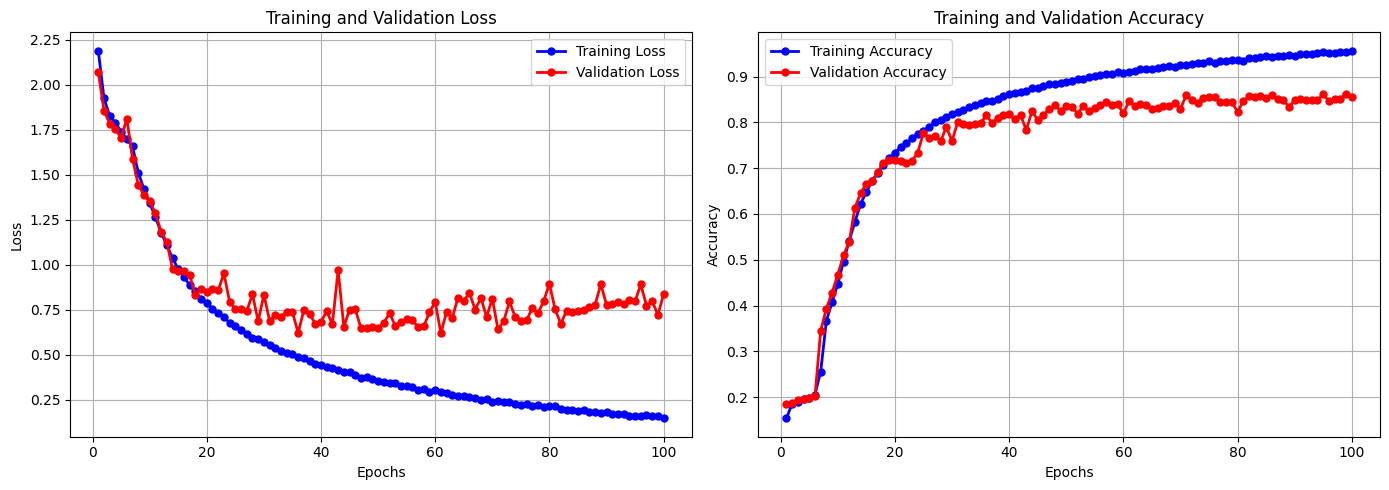

In [17]:
plot_training_history(trainer_vgg16.history)

# <a id='toc5_'></a>[Pruning](#toc0_)

In [7]:
def scan_curve_vals(scanner: scanner.SensitivityScanner,
              layers: list[str],
              step_size: int = 0.1):

  accuracy_dict = {}

  for idx,layer in enumerate(layers):
    sparsity_levels = [i * step_size for i in range(int(1/step_size))]
    accuracies = []
    for sparsity in sparsity_levels:
      loss, accuracy = scanner.individual_layer_scan(layer,sparsity)
      accuracies.append(accuracy)
    accuracy_dict.update({layer:accuracies})


  return accuracy_dict

import matplotlib.pyplot as plt

def plot_sensitivity_curves(scan_dict: dict,
                            step_size: float = 0.1,
                            threshold_accuracy: float = 0.5):
    """
    Plots sensitivity curves for each layer based on the provided accuracies after pruning.

    Args:
        scan_dict (dict): A dictionary containing layer names as keys and a list of accuracies as values.
        step_size (float): The step size used for sparsity levels.
    """
    sparsity_levels = [i * step_size for i in range(int(1 / step_size))]

    num_layers = len(scan_dict)
    num_columns = 3
    num_rows = num_layers // num_columns + (num_layers % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows), constrained_layout=True)

    # Flatten the axis array for easy iteration
    axs = axs.flatten()

    # Plot each layer's sensitivity curve
    for idx, (layer_name, accuracies) in enumerate(scan_dict.items()):
        ax = axs[idx]
        ax.plot(sparsity_levels, accuracies, 'b.-', label='accuracy after pruning')  # Blue dots with lines
        ax.set_title(layer_name)
        ax.set_xlabel('Sparsity')
        ax.set_ylabel('Accuracy')
        ax.axhline(y=threshold_accuracy, color='orange', linestyle='--', label=f'threshold')
        ax.set_ylim([0.0, 1.0])
        ax.grid(True)

        # Add the legend to the first subplot for clarity
        if idx == 0:
            ax.legend()

    # Hide any unused subplots
    for ax in axs[num_layers:]:
        ax.set_visible(False)

    plt.show()




## <a id='toc5_1_'></a>[Finegrained Pruning](#toc0_)

In [8]:
vgg16_finegrained = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

vgg16_finegrained.load_state_dict(torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_main.pt',
                                 map_location=torch.device(DEVICE)))

vgg16 = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

vgg16.load_state_dict(torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_main.pt',
                                 map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [10]:
# Dummy sparsity levels
sparsity_levels = {'conv0':0.1,
                   'conv1':0.2,
                   'conv2':0.7,
                   'conv3':0.8,
                   'conv4':0.6,
                   'conv5':0.8,
                   'conv6':0.5,
                   'conv7':0.1,
                   'conv8':0.6,
                   'conv9':0.7,
                   'conv10':0.5,
                   'conv11':0.7}

In [11]:
fingrained_scanner = scanner.SensitivityScanner(
    _model = vgg16_finegrained,
    dataloader = dataloader['test'],
    device = DEVICE,
    criterion = nn.CrossEntropyLoss(),
    _pruner = 'finegrained',
    sparsity_levels = sparsity_levels
)

In [12]:
layers_sensitivity_curves = ['conv0',
                   'conv1',
                   'conv2',
                   'conv3',
                   'conv4',
                   'conv5',
                   'conv6',
                   'conv7',
                   'conv8',
                   'conv9',
                   'conv10',
                   'conv11']


In [14]:
scan_dict = scan_curve_vals(fingrained_scanner,
                      layers_sensitivity_curves,)

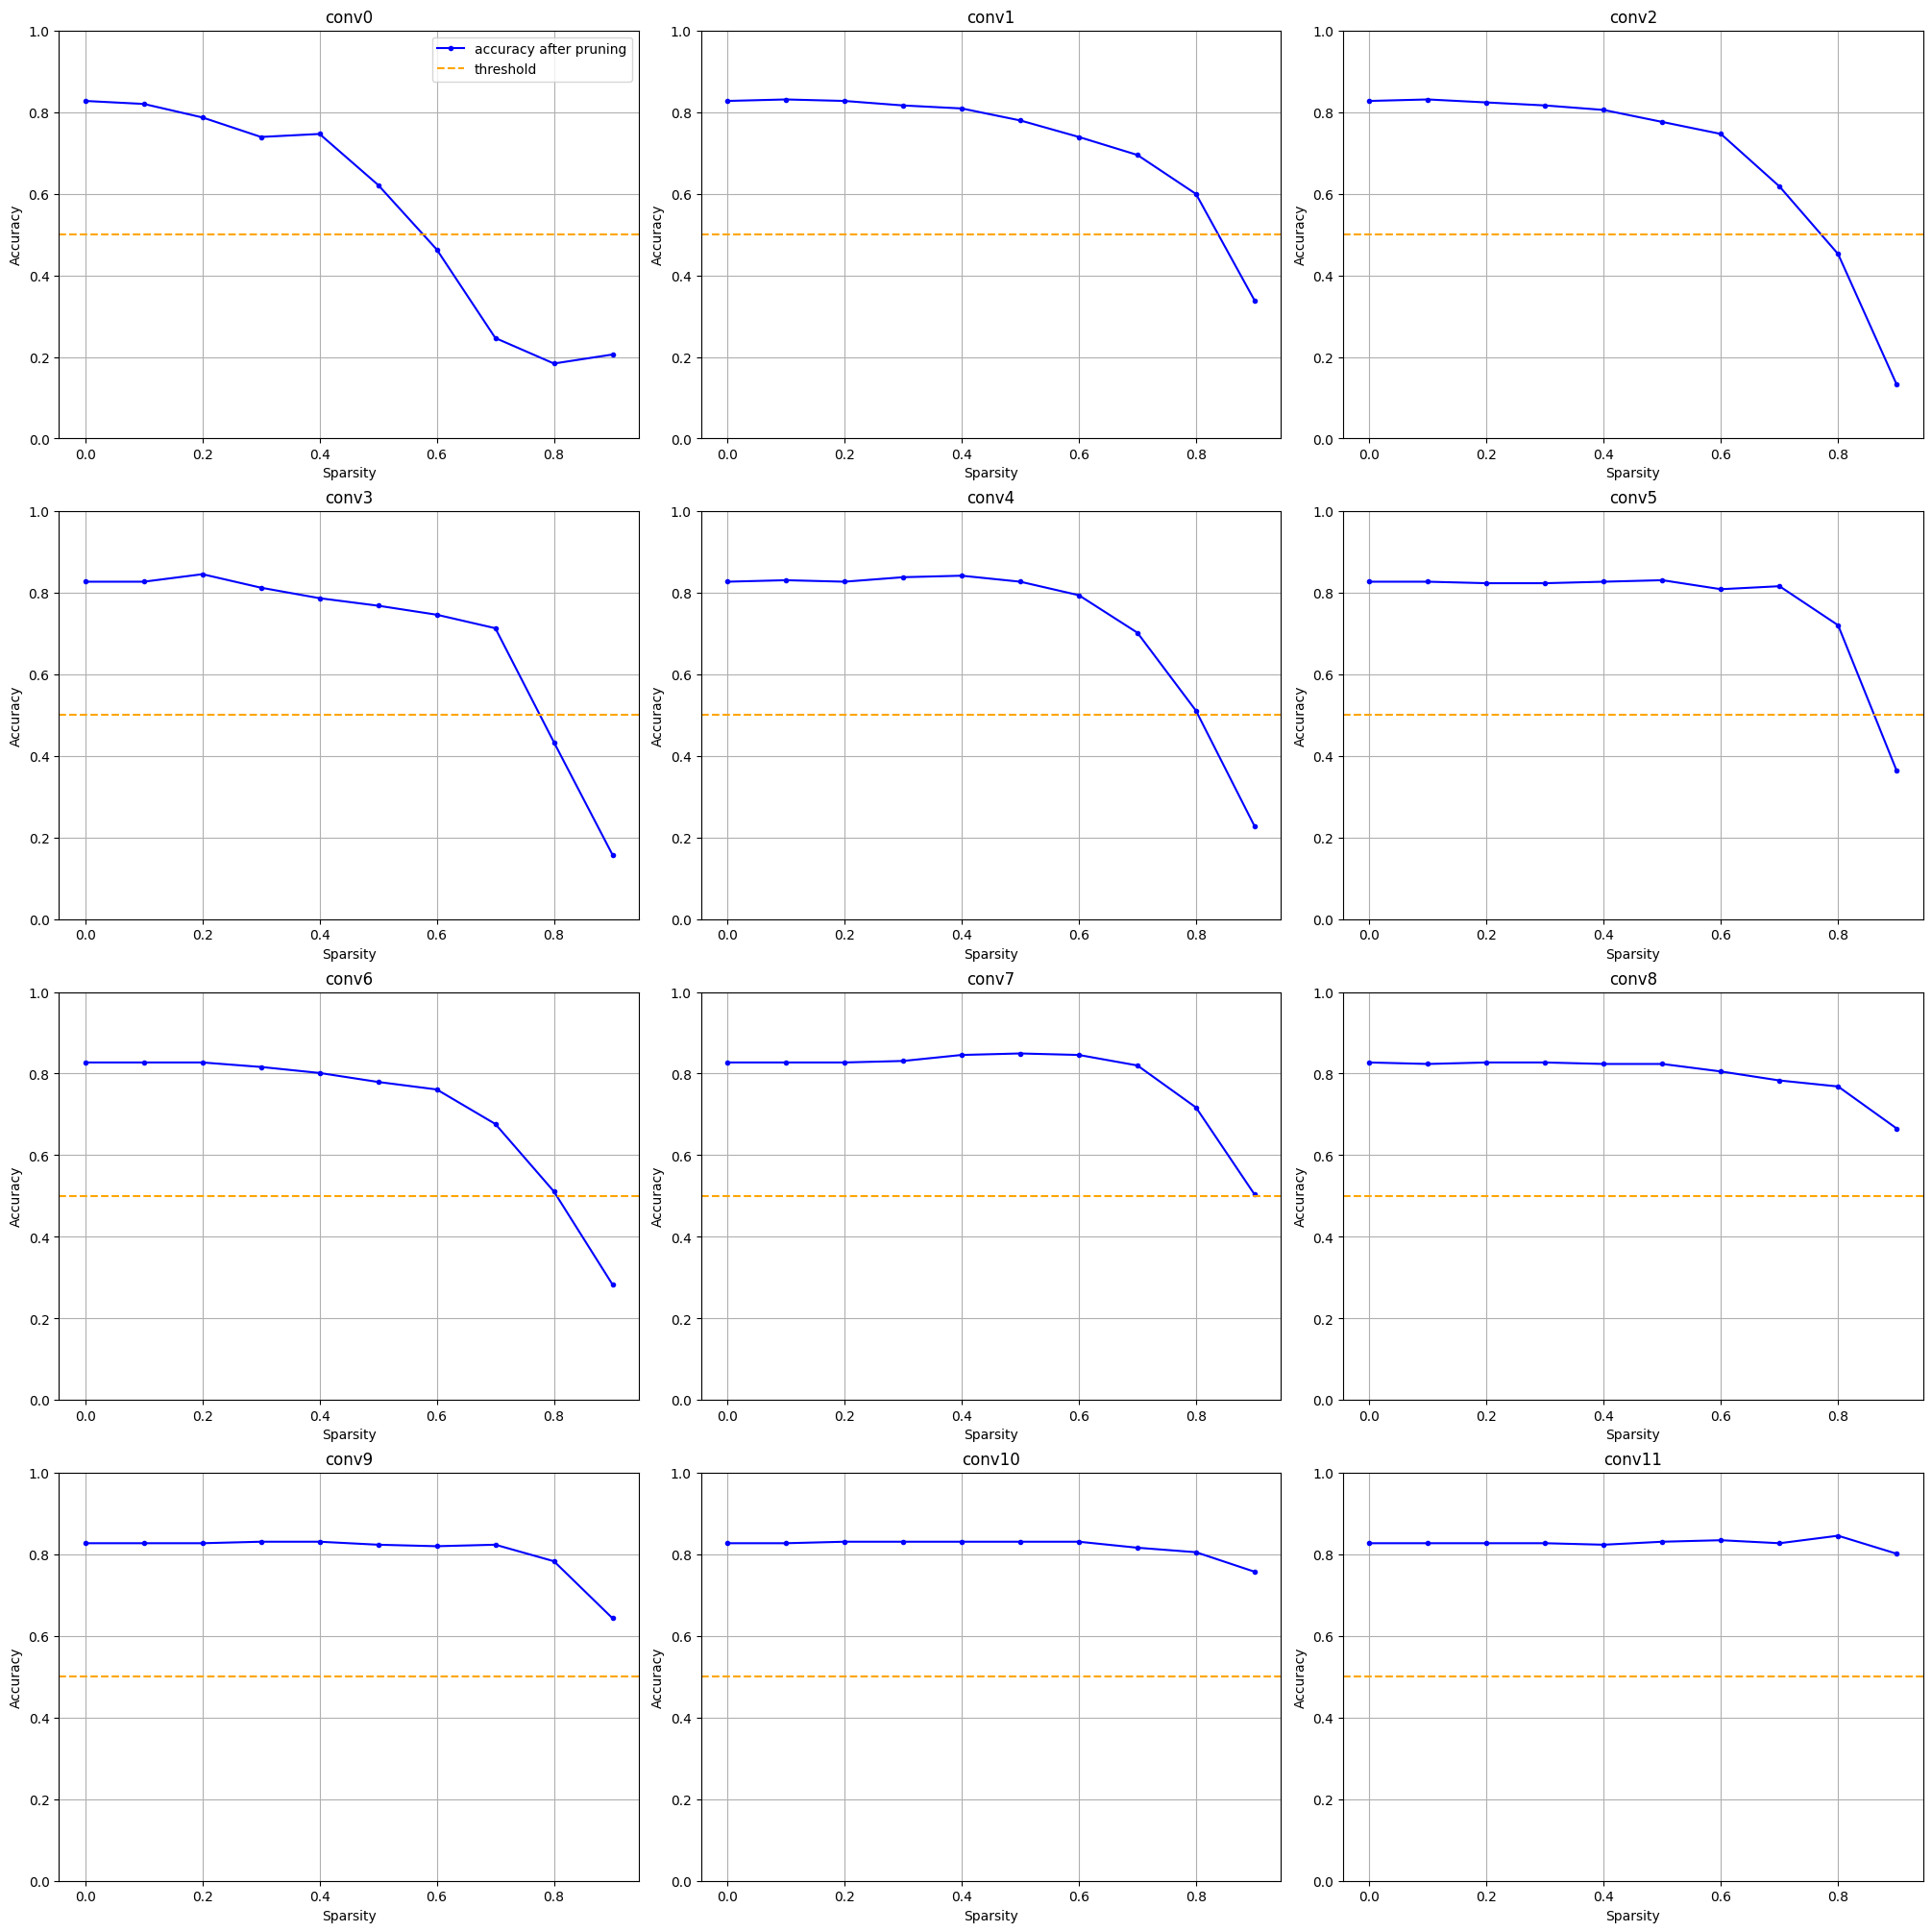

In [15]:
plot_sensitivity_curves(scan_dict)

Got some interesting results based on pruning.

In [13]:
fingrained_scanner.sparsity_levels = {'conv0':0.5,
                   'conv1':0.8,
                   'conv2':0.7,
                   'conv3':0.7,
                   'conv4':0.7,
                   'conv5':0.8,
                   'conv6':0.7,
                   'conv7':0.8,
                   'conv8':0.8,
                   'conv9':0.8,
                   'conv10':0.9,
                   'conv11':0.9}

In [14]:
# Create pruner object to prune model
finegrained_pruner = pruner.PrunerFinegrained(vgg16_finegrained.features,
                                              fingrained_scanner.sparsity_levels)

In [15]:
finegrained_masks = finegrained_pruner.get_masks()

In [16]:
# Percentage left
(utils.get_num_parameters(vgg16_finegrained, count_nonzero_only=True)/utils.get_num_parameters(vgg16, count_nonzero_only=True)).item()

0.20495903491973877

### <a id='toc5_1_1_'></a>[Finetuning](#toc0_)

In [17]:
finegrained_configs = trainer.TrainConfigs(
    learning_rate = 1e-4,
    epochs=20,
    batch_size = 64,
    loss_fn = nn.CrossEntropyLoss(),
    device = DEVICE
)

In [18]:
vgg16_finegrained_optimizer = torch.optim.Adam(vgg16_finegrained.parameters(),lr=finegrained_configs.learning_rate)

In [19]:
trainer_vgg16_finegrained = trainer.Trainer(finegrained_configs,
                                vgg16_finegrained,
                                vgg16_finegrained_optimizer,
                                dataloader['train'],
                                dataloader['test'],
                                finegrained_masks)

In [20]:
trainer_vgg16_finegrained.validate()

  0%|          | 0/20 [00:00<?, ?it/s]

(4.6393838905334475, 0.1)

In [32]:
trainer_vgg16_finegrained.train()

Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20: Train Loss: 1.2413 | Train Acc: 0.6434 | Val Loss: 0.8806 | Val Acc: 0.7278


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/20: Train Loss: 0.7775 | Train Acc: 0.7553 | Val Loss: 0.7382 | Val Acc: 0.7759


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/20: Train Loss: 0.6485 | Train Acc: 0.7967 | Val Loss: 0.7035 | Val Acc: 0.7962


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/20: Train Loss: 0.5825 | Train Acc: 0.8214 | Val Loss: 0.6757 | Val Acc: 0.7999


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/20: Train Loss: 0.5260 | Train Acc: 0.8359 | Val Loss: 0.6547 | Val Acc: 0.8119


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/20: Train Loss: 0.4948 | Train Acc: 0.8468 | Val Loss: 0.6359 | Val Acc: 0.8185


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/20: Train Loss: 0.4676 | Train Acc: 0.8555 | Val Loss: 0.6065 | Val Acc: 0.8229


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/20: Train Loss: 0.4413 | Train Acc: 0.8630 | Val Loss: 0.6282 | Val Acc: 0.8232


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/20: Train Loss: 0.4193 | Train Acc: 0.8703 | Val Loss: 0.5926 | Val Acc: 0.8291


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/20: Train Loss: 0.4020 | Train Acc: 0.8764 | Val Loss: 0.5960 | Val Acc: 0.8320


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/20: Train Loss: 0.3824 | Train Acc: 0.8823 | Val Loss: 0.5920 | Val Acc: 0.8379


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/20: Train Loss: 0.3691 | Train Acc: 0.8846 | Val Loss: 0.5984 | Val Acc: 0.8366


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/20: Train Loss: 0.3579 | Train Acc: 0.8887 | Val Loss: 0.5951 | Val Acc: 0.8404


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/20: Train Loss: 0.3444 | Train Acc: 0.8938 | Val Loss: 0.5931 | Val Acc: 0.8438


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/20: Train Loss: 0.3356 | Train Acc: 0.8952 | Val Loss: 0.6019 | Val Acc: 0.8461


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/20: Train Loss: 0.3341 | Train Acc: 0.8984 | Val Loss: 0.5960 | Val Acc: 0.8465


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/20: Train Loss: 0.3116 | Train Acc: 0.9020 | Val Loss: 0.6143 | Val Acc: 0.8471


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/20: Train Loss: 0.3124 | Train Acc: 0.9035 | Val Loss: 0.6190 | Val Acc: 0.8468


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/20: Train Loss: 0.2967 | Train Acc: 0.9069 | Val Loss: 0.6202 | Val Acc: 0.8441


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/20: Train Loss: 0.2939 | Train Acc: 0.9092 | Val Loss: 0.6138 | Val Acc: 0.8466


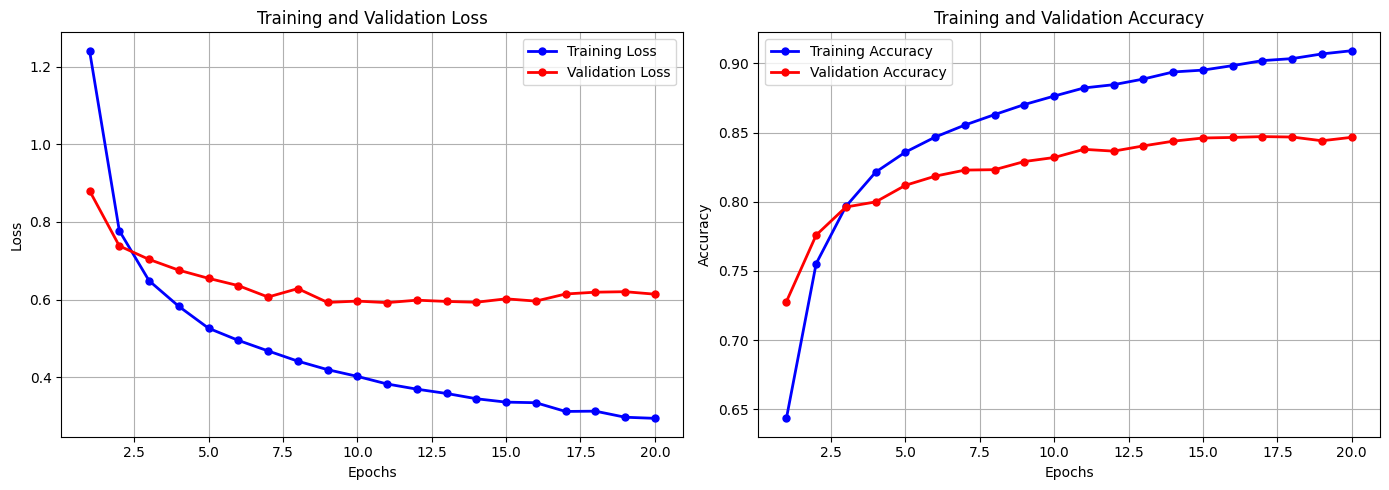

In [33]:
plot_training_history(trainer_vgg16_finegrained.history)

In [34]:
trainer_vgg16_finegrained.save_model('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_finegrained.pt')

## <a id='toc5_2_'></a>[Kernel Pruning](#toc0_)



In [8]:
vgg16_kernel = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

vgg16_kernel.load_state_dict(torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_main.pt',
                                        map_location=torch.device(DEVICE)))

vgg16 = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

vgg16.load_state_dict(torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_main.pt',
                                 map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [9]:
# Dummy sparsity levels
sparsity_levels = {'conv0':0.1,
                   'conv1':0.2,
                   'conv2':0.7,
                   'conv3':0.8,
                   'conv4':0.6,
                   'conv5':0.8,
                   'conv6':0.5,
                   'conv7':0.1,
                   'conv8':0.6,
                   'conv9':0.7,
                   'conv10':0.5,
                   'conv11':0.7}

In [10]:
kernel_scanner = scanner.SensitivityScanner(
    _model = vgg16_kernel,
    dataloader = dataloader['test'],
    device = DEVICE,
    criterion = nn.CrossEntropyLoss(),
    _pruner = 'kernel',
    sparsity_levels = sparsity_levels
)

In [11]:
layers_sensitivity_curves = ['conv0',
                   'conv1',
                   'conv2',
                   'conv3',
                   'conv4',
                   'conv5',
                   'conv6',
                   'conv7',
                   'conv8',
                   'conv9',
                   'conv10',
                   'conv11']

In [39]:
scan_dict = scan_curve_vals(kernel_scanner,
                            layers_sensitivity_curves,)

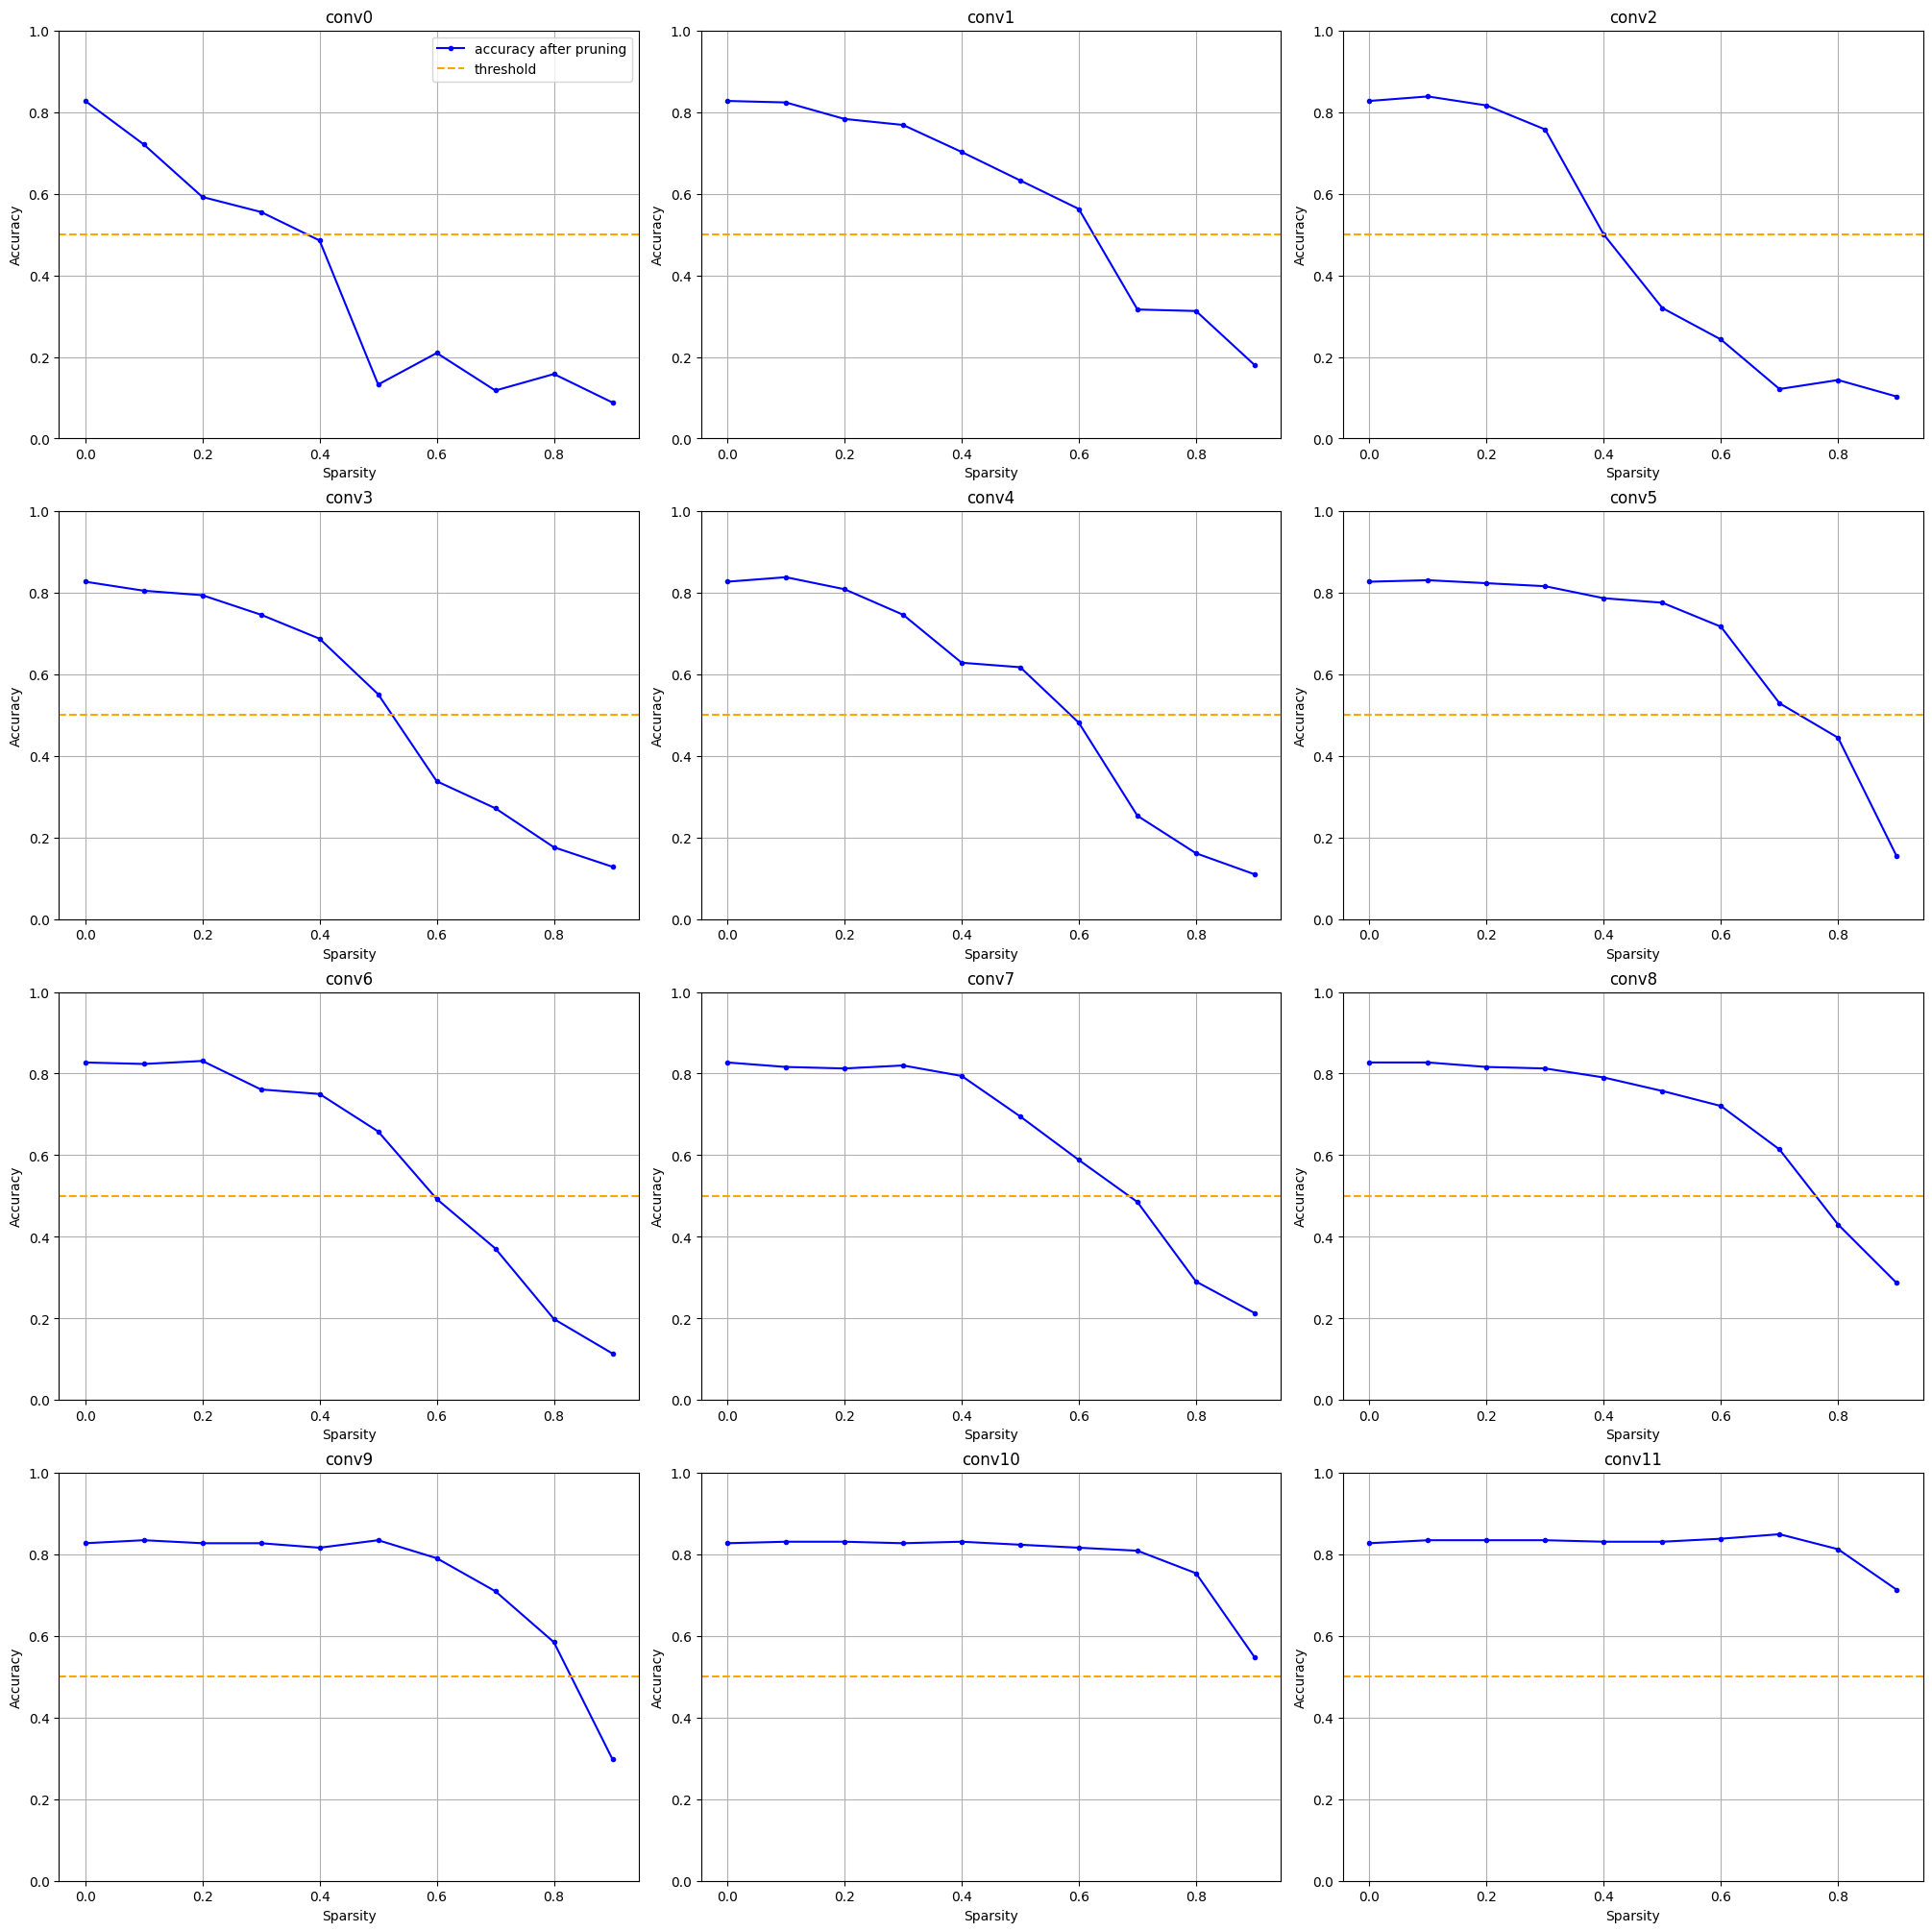

In [40]:
plot_sensitivity_curves(scan_dict)

In [12]:
kernel_scanner.sparsity_levels = {'conv0':0.3,
                   'conv1':0.6,
                   'conv2':0.3,
                   'conv3':0.5,
                   'conv4':0.5,
                   'conv5':0.7,
                   'conv6':0.6,
                   'conv7':0.6,
                   'conv8':0.7,
                   'conv9':0.8,
                   'conv10':0.9,
                   'conv11':0.9}

In [13]:
# Create pruner object to prune model
kernel_pruner = pruner.PrunerKernel(vgg16_kernel.features,
                                    kernel_scanner.sparsity_levels)

In [14]:
kernel_masks = kernel_pruner.get_masks()

In [15]:
# Percentage pruned
(utils.get_num_parameters(vgg16_kernel, count_nonzero_only=True)/utils.get_num_parameters(vgg16, count_nonzero_only=True)).item()

0.23954185843467712

### <a id='toc5_2_1_'></a>[Finetuning](#toc0_)

In [16]:
kernel_configs = trainer.TrainConfigs(
    learning_rate = 1e-4,
    epochs=20,
    batch_size = 64,
    loss_fn = nn.CrossEntropyLoss(),
    device = DEVICE
)

In [17]:
vgg16_kernel_optimizer = torch.optim.Adam(vgg16_kernel.parameters(),lr=kernel_configs.learning_rate)

In [18]:
trainer_vgg16_kernel = trainer.Trainer(kernel_configs,
                                vgg16_kernel,
                                vgg16_kernel_optimizer,
                                dataloader['train'],
                                dataloader['test'],
                                kernel_masks)

In [19]:
trainer_vgg16_kernel.validate()

  0%|          | 0/20 [00:00<?, ?it/s]

(4.721016040039062, 0.1)

In [20]:
trainer_vgg16_kernel.train()

Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20: Train Loss: 2.0557 | Train Acc: 0.4425 | Val Loss: 1.2493 | Val Acc: 0.5672


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/20: Train Loss: 1.2143 | Train Acc: 0.5921 | Val Loss: 1.0662 | Val Acc: 0.6439


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/20: Train Loss: 1.0179 | Train Acc: 0.6663 | Val Loss: 0.9079 | Val Acc: 0.7048


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/20: Train Loss: 0.8948 | Train Acc: 0.7142 | Val Loss: 0.8308 | Val Acc: 0.7366


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/20: Train Loss: 0.8098 | Train Acc: 0.7404 | Val Loss: 0.7911 | Val Acc: 0.7522


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/20: Train Loss: 0.7428 | Train Acc: 0.7643 | Val Loss: 0.7547 | Val Acc: 0.7649


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/20: Train Loss: 0.6984 | Train Acc: 0.7793 | Val Loss: 0.7196 | Val Acc: 0.7777


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/20: Train Loss: 0.6593 | Train Acc: 0.7921 | Val Loss: 0.7067 | Val Acc: 0.7899


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/20: Train Loss: 0.6201 | Train Acc: 0.8051 | Val Loss: 0.6830 | Val Acc: 0.7951


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/20: Train Loss: 0.5985 | Train Acc: 0.8128 | Val Loss: 0.6803 | Val Acc: 0.7986


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/20: Train Loss: 0.5668 | Train Acc: 0.8213 | Val Loss: 0.6652 | Val Acc: 0.8047


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/20: Train Loss: 0.5410 | Train Acc: 0.8324 | Val Loss: 0.6430 | Val Acc: 0.8124


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/20: Train Loss: 0.5219 | Train Acc: 0.8368 | Val Loss: 0.6321 | Val Acc: 0.8138


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/20: Train Loss: 0.5039 | Train Acc: 0.8429 | Val Loss: 0.6124 | Val Acc: 0.8201


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/20: Train Loss: 0.4884 | Train Acc: 0.8481 | Val Loss: 0.6169 | Val Acc: 0.8234


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/20: Train Loss: 0.4687 | Train Acc: 0.8535 | Val Loss: 0.6222 | Val Acc: 0.8243


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/20: Train Loss: 0.4555 | Train Acc: 0.8580 | Val Loss: 0.6357 | Val Acc: 0.8226


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/20: Train Loss: 0.4409 | Train Acc: 0.8624 | Val Loss: 0.6284 | Val Acc: 0.8255


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/20: Train Loss: 0.4291 | Train Acc: 0.8649 | Val Loss: 0.6069 | Val Acc: 0.8307


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/20: Train Loss: 0.4206 | Train Acc: 0.8681 | Val Loss: 0.6346 | Val Acc: 0.8258


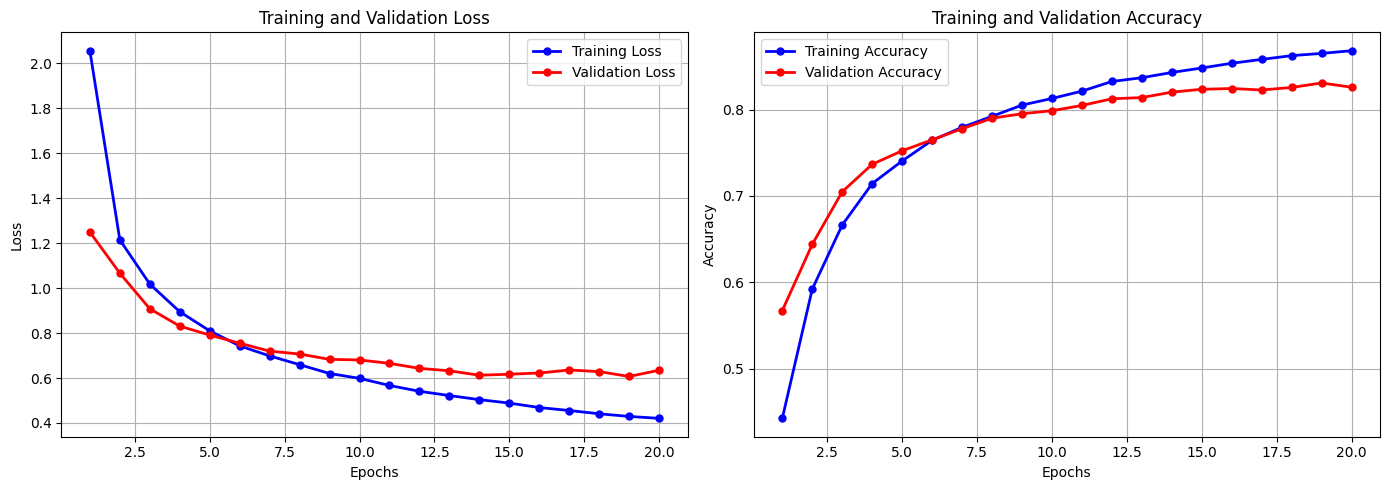

In [21]:
plot_training_history(trainer_vgg16_kernel.history)

In [22]:
trainer_vgg16_kernel.save_model('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_kernel.pt')

## <a id='toc5_3_'></a>[Filter Pruning](#toc0_)



In [23]:
vgg16_filter = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

vgg16_filter.load_state_dict(torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_main.pt',
                                 map_location=torch.device(DEVICE)))

vgg16 = model.VGG16(
    num_classes=10,
    input_shape=(32,32)
).to(DEVICE)

vgg16.load_state_dict(torch.load('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_main.pt',
                                 map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [37]:
import copy
vgg_filter = copy.deepcopy(vgg16)

In [38]:
# Dummy sparsity levels
sparsity_levels = {'conv0':0.1,
                   'conv1':0.2,
                   'conv2':0.7,
                   'conv3':0.8,
                   'conv4':0.6,
                   'conv5':0.8,
                   'conv6':0.5,
                   'conv7':0.1,
                   'conv8':0.6,
                   'conv9':0.7,
                   'conv10':0.5,
                   'conv11':0.7}

In [39]:
filter_scanner = scanner.SensitivityScanner(
    _model = vgg16_filter,
    dataloader = dataloader['test'],
    device = DEVICE,
    criterion = nn.CrossEntropyLoss(),
    _pruner = 'filter',
    sparsity_levels = sparsity_levels
)

In [40]:
layers_sensitivity_curves = ['conv0',
                   'conv1',
                   'conv2',
                   'conv3',
                   'conv4',
                   'conv5',
                   'conv6',
                   'conv7',
                   'conv8',
                   'conv9',
                   'conv10',
                   'conv11']

In [27]:
scan_dict = scan_curve_vals(filter_scanner,
                            layers_sensitivity_curves,)

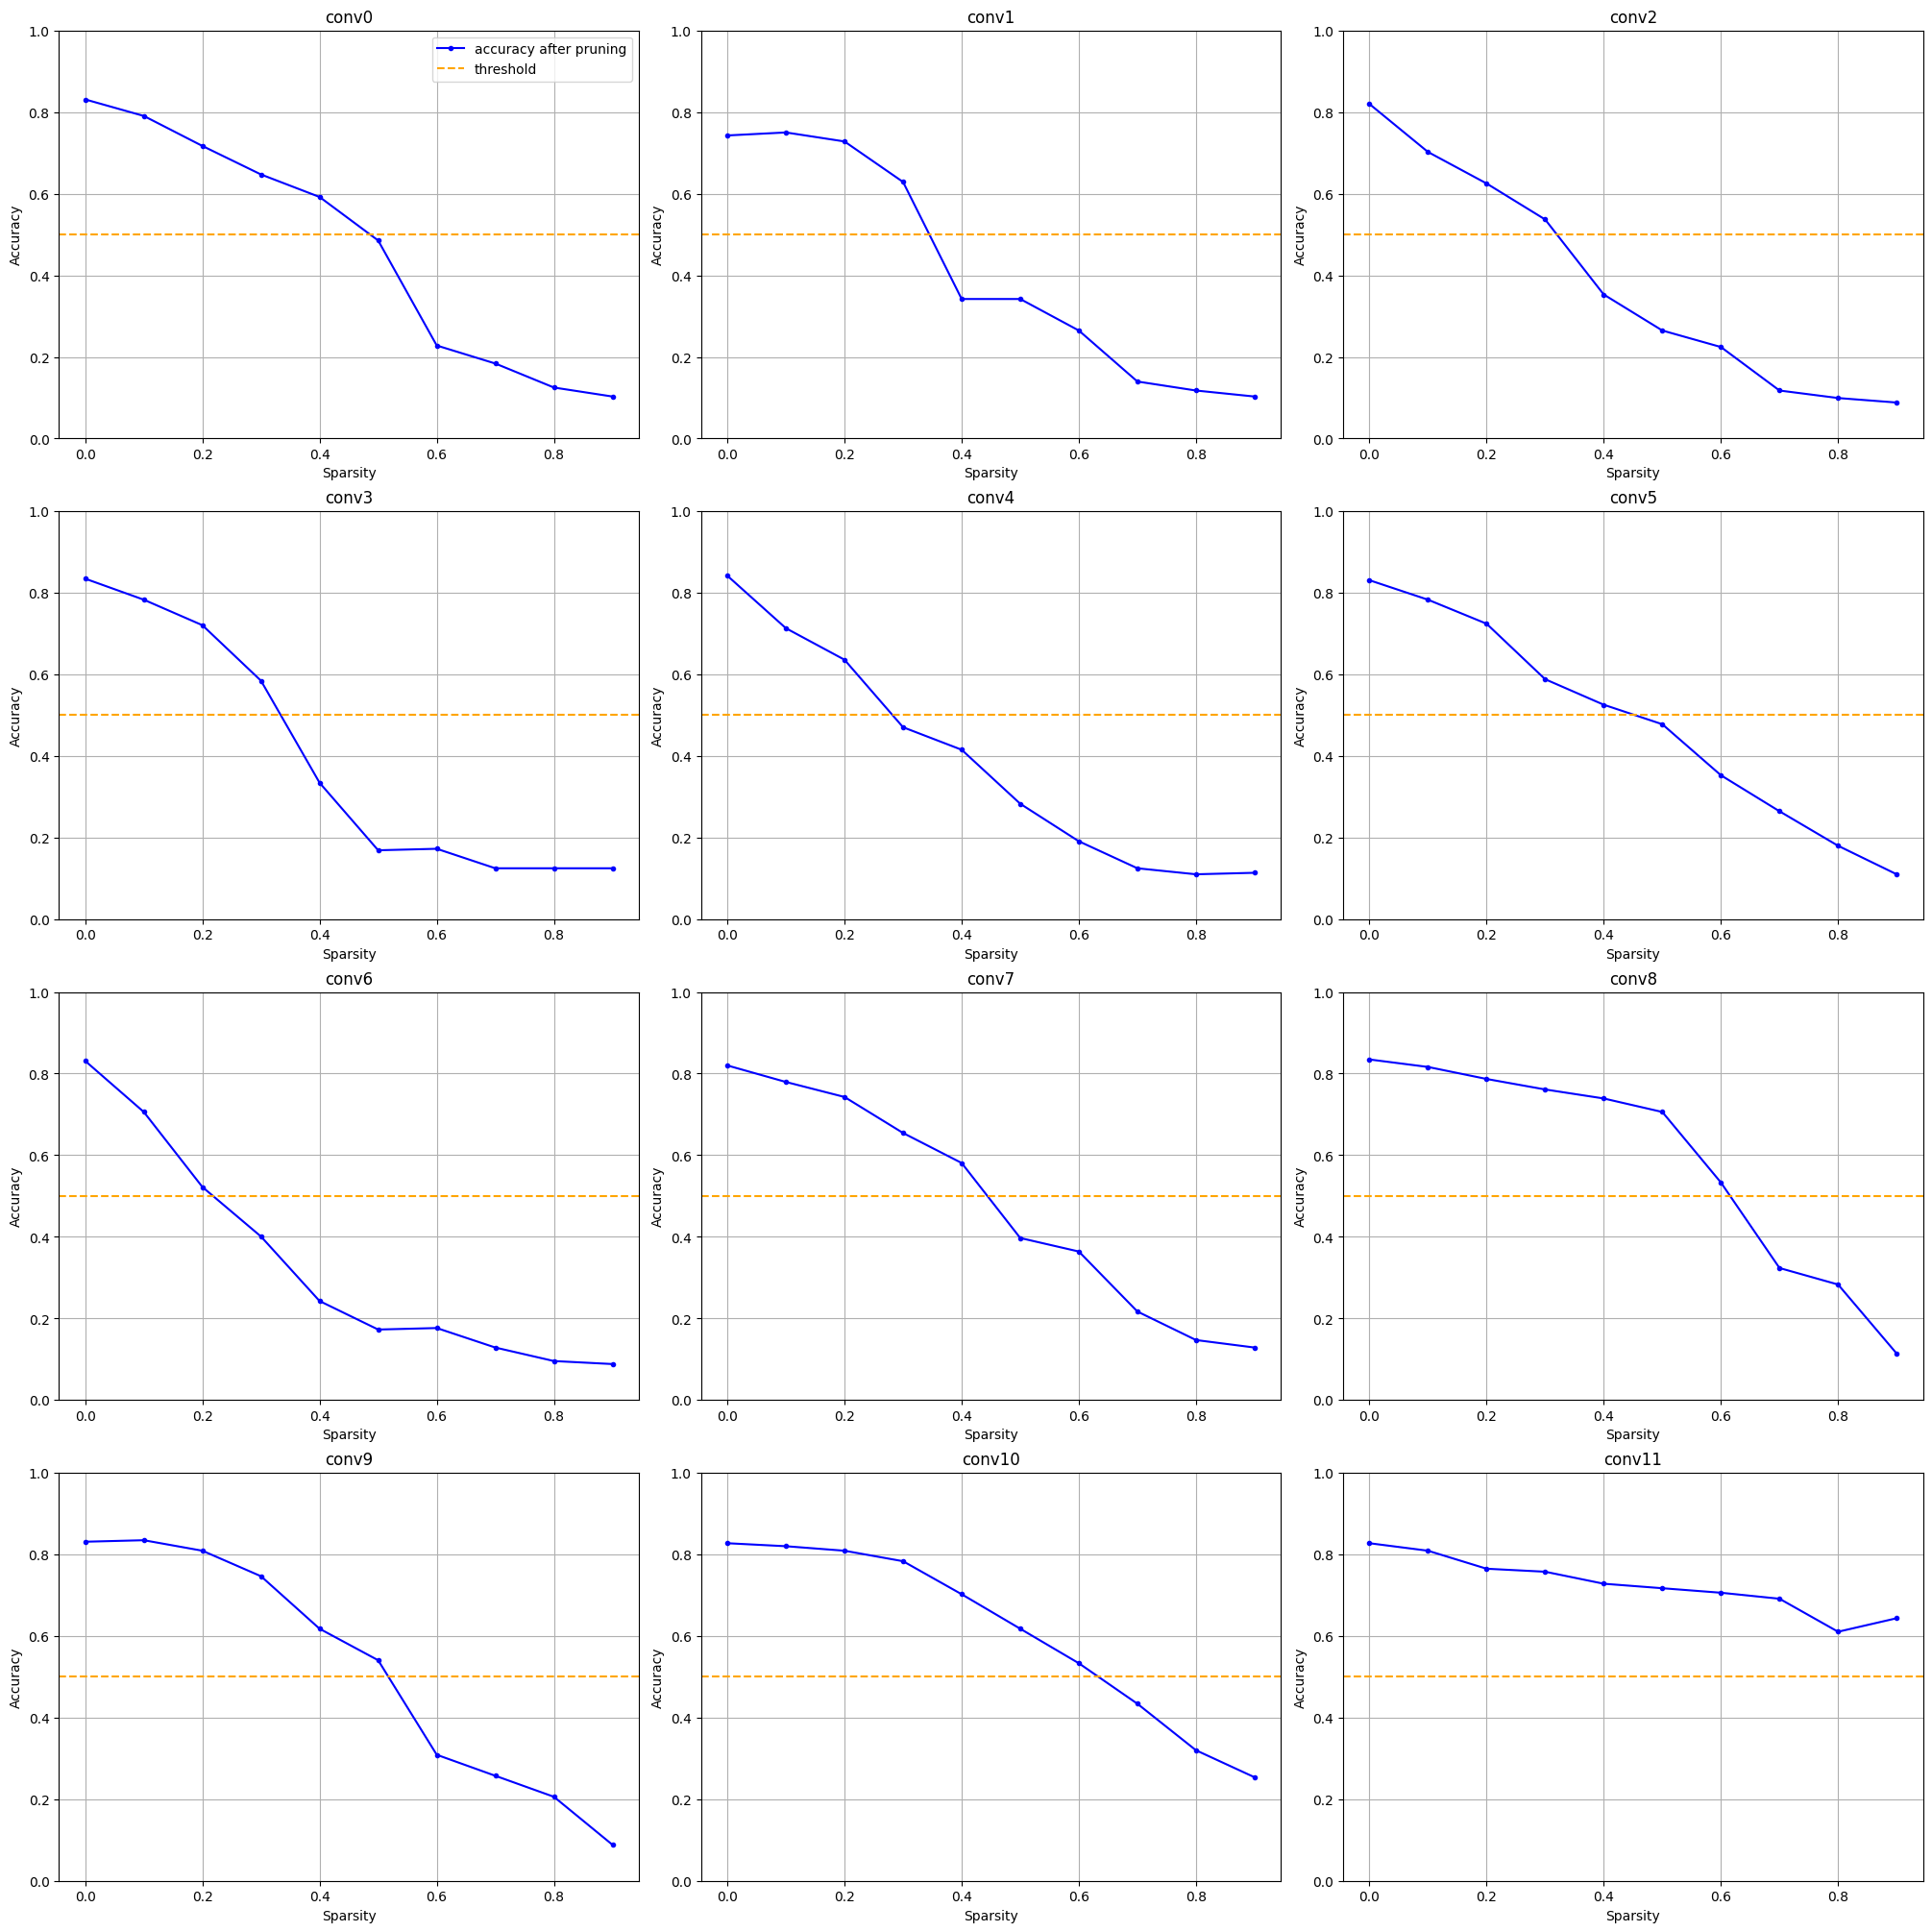

In [28]:
plot_sensitivity_curves(scan_dict)

In [41]:
filter_scanner.sparsity_levels = {'conv0':0.4,
                   'conv1':0.3,
                   'conv2':0.3,
                   'conv3':0.3,
                   'conv4':0.2,
                   'conv5':0.4,
                   'conv6':0.2,
                   'conv7':0.4,
                   'conv8':0.6,
                   'conv9':0.5,
                   'conv10':0.6,
                   'conv11':0.9}

In [42]:
# Create pruner object to prune model
filter_pruner = pruner.PrunerFilter(vgg16_filter.features,
                                    filter_scanner.sparsity_levels)

In [43]:
filter_masks = filter_pruner.get_masks()

In [44]:
# Percentage pruned
(utils.get_num_parameters(vgg16_filter, count_nonzero_only=True)/utils.get_num_parameters(vgg16, count_nonzero_only=True)).item()

0.4149166941642761

### <a id='toc5_3_1_'></a>[Finetuning](#toc0_)

In [45]:
filter_configs = trainer.TrainConfigs(
    learning_rate = 1e-4,
    epochs=25,
    batch_size = 64,
    loss_fn = nn.CrossEntropyLoss(),
    device = DEVICE
)

In [46]:
vgg16_filter_optimizer = torch.optim.Adam(vgg16_filter.parameters(),lr=filter_configs.learning_rate)

In [47]:
trainer_vgg16_filter = trainer.Trainer(filter_configs,
                                vgg16_filter,
                                vgg16_filter_optimizer,
                                dataloader['train'],
                                dataloader['test'],
                                filter_masks)

In [48]:
trainer_vgg16_filter.validate()

  0%|          | 0/20 [00:00<?, ?it/s]

(2.6928184459686277, 0.1)

In [49]:
trainer_vgg16_filter.train()

Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/25: Train Loss: 1.3859 | Train Acc: 0.5290 | Val Loss: 1.0536 | Val Acc: 0.6523


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/25: Train Loss: 0.9225 | Train Acc: 0.7070 | Val Loss: 0.8153 | Val Acc: 0.7369


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/25: Train Loss: 0.7805 | Train Acc: 0.7587 | Val Loss: 0.8012 | Val Acc: 0.7463


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/25: Train Loss: 0.7010 | Train Acc: 0.7859 | Val Loss: 0.6922 | Val Acc: 0.7834


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/25: Train Loss: 0.6373 | Train Acc: 0.8056 | Val Loss: 0.7692 | Val Acc: 0.7727


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/25: Train Loss: 0.5990 | Train Acc: 0.8176 | Val Loss: 0.7007 | Val Acc: 0.7855


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/25: Train Loss: 0.5658 | Train Acc: 0.8285 | Val Loss: 0.6079 | Val Acc: 0.8177


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/25: Train Loss: 0.5398 | Train Acc: 0.8362 | Val Loss: 0.6666 | Val Acc: 0.8017


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/25: Train Loss: 0.5098 | Train Acc: 0.8458 | Val Loss: 0.5981 | Val Acc: 0.8232


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/25: Train Loss: 0.4900 | Train Acc: 0.8536 | Val Loss: 0.6086 | Val Acc: 0.8216


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/25: Train Loss: 0.4678 | Train Acc: 0.8583 | Val Loss: 0.6183 | Val Acc: 0.8186


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/25: Train Loss: 0.4654 | Train Acc: 0.8597 | Val Loss: 0.7193 | Val Acc: 0.8033


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/25: Train Loss: 0.4481 | Train Acc: 0.8659 | Val Loss: 0.5756 | Val Acc: 0.8279


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/25: Train Loss: 0.4350 | Train Acc: 0.8711 | Val Loss: 0.6445 | Val Acc: 0.8253


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/25: Train Loss: 0.4161 | Train Acc: 0.8744 | Val Loss: 0.5815 | Val Acc: 0.8338


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/25: Train Loss: 0.4048 | Train Acc: 0.8774 | Val Loss: 0.6740 | Val Acc: 0.8191


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/25: Train Loss: 0.3936 | Train Acc: 0.8811 | Val Loss: 0.6187 | Val Acc: 0.8324


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/25: Train Loss: 0.3805 | Train Acc: 0.8853 | Val Loss: 0.6034 | Val Acc: 0.8344


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/25: Train Loss: 0.3701 | Train Acc: 0.8888 | Val Loss: 0.6227 | Val Acc: 0.8252


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/25: Train Loss: 0.3661 | Train Acc: 0.8894 | Val Loss: 0.6184 | Val Acc: 0.8351


Training:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/25: Train Loss: 0.3564 | Train Acc: 0.8937 | Val Loss: 0.5930 | Val Acc: 0.8344


Training:   0%|          | 0/98 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [50]:
trainer_vgg16_filter.validate()

  0%|          | 0/20 [00:00<?, ?it/s]

(0.5865868381500244, 0.8358)

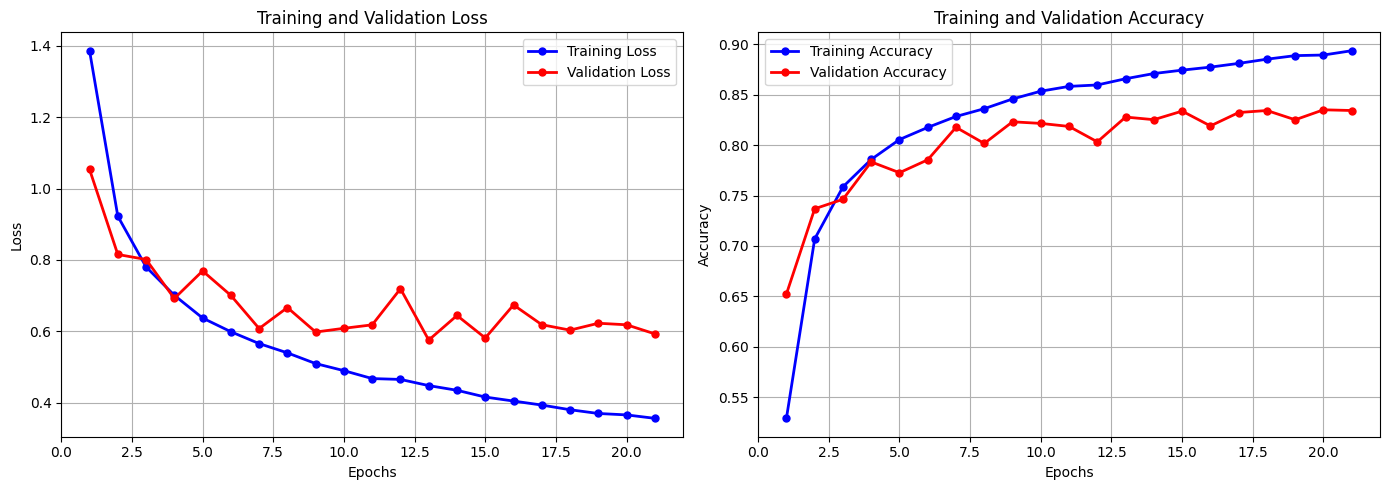

In [51]:
plot_training_history(trainer_vgg16_filter.history)

In [52]:
trainer_vgg16_filter.save_model('/content/drive/MyDrive/SAiDL-2024/Pruning-Sparsity/vgg16_filter.pt')